## Кейс 2 - определение ССЗ

ссылка на соревнование - https://mlbootcamp.ru/ru/round/12/sandbox/

В идеале бы конечно всех людей отправить на обследования, но количество тестов ограничено, бюджет ограничен, поэтому нужно отбирать только тех людей, у которых повышен риск сердечно-сосудистых заболеваний.

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

Ссылка на google drive: https://drive.google.com/file/d/1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G

In [1]:
!wget 'https://drive.google.com/uc?export=download&id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G' -O train_case2.csv

--2022-04-02 19:10:04--  https://drive.google.com/uc?export=download&id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G
Распознаётся drive.google.com (drive.google.com)... 216.58.211.14, 2a00:1450:400f:80d::200e
Подключение к drive.google.com (drive.google.com)|216.58.211.14|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа... 303 See Other
Адрес: https://doc-00-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vk2cb4saumsp4bksbqkkod9s3ptrr2ku/1648915800000/14904333240138417226/*/1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G?e=download [переход]
Предупреждение: в HTTP шаблоны не поддерживаются.
--2022-04-02 19:10:05--  https://doc-00-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vk2cb4saumsp4bksbqkkod9s3ptrr2ku/1648915800000/14904333240138417226/*/1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G?e=download
Распознаётся doc-00-c0-docs.googleusercontent.com (doc-00-c0-docs.googleusercontent.com)... 216.58.207.193, 2a00:1450:400f:80b::2001
Подключение

In [2]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

In [4]:
import seaborn as sns
import itertools
import matplotlib.pyplot as plt

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

/home/recpi/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [7]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='cardio'), 
                                                    df['cardio'], random_state=0)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [8]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [9]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификатор и запустим кросс-валидацию

In [10]:
def init_models():
    model_lr = LogisticRegression(random_state=21)
    model_knn = KNeighborsClassifier()
    model_tree = DecisionTreeClassifier(random_state=21)
    model_xgb = xgb.XGBClassifier(random_state=21)
    model_lgbm = lgbm.LGBMClassifier(random_state=21)
    model_catb = catb.CatBoostClassifier(silent=True, random_state=21)

    models = {
        'lr': model_lr,
        'knn': model_knn,
        'tree': model_tree,
        'xgb': model_xgb,
        'lgbm': model_lgbm,
        'cat': model_catb
    }
    return models

In [11]:
def business_threshold_calibrate(y_test, y_score, thresholds,
                                 rubl_test=100, rubl_early_treatment=100, rubl_late_treatment=1000):
    business_threshold = 0
    r_test_all_r_ML_ = 0

    rubl_ML_ = 1_000_000_000 

    rs = []
    n = 20
    for opt_buisness_tr in np.linspace(0, 1, n).tolist():
        # подберем порог для улучшения бизнесс показателя

        cnf_matrix = confusion_matrix(y_test, y_score > (opt_buisness_tr))
        TN = cnf_matrix[0][0]
        FN = cnf_matrix[1][0]
        TP = cnf_matrix[1][1]
        FP = cnf_matrix[0][1]

        rubl_1 = (TP + FN) * rubl_late_treatment
        rubl_test_all = np.sum(cnf_matrix) * rubl_test + (FN + TP) * rubl_early_treatment
        rubl_ML = (TP + FP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
        
        r_test_all_r_ML = rubl_test_all - rubl_ML 
        
        if rubl_ML < rubl_ML_:            
            business_threshold = opt_buisness_tr
            
            rubl_ML_ = rubl_ML
            
        rs.append(rubl_ML)   
            
    
    print('расходы, если не делать тест и ждать симптомов:', rubl_1)
    print('расходы, если делать тест всем и лечить группу больных:', rubl_test_all)
    print('расходы, если использовать МЛ:', rubl_ML_)

    print('Расходы "решение не делать тесты - расходы с МL:"', rubl_1 - rubl_ML_)
    print('Расходы "решение не делать тесты - расходы сделать тесты всем":', rubl_1 - rubl_test_all)
    print('Расходы "сделать тесты всем - решение делать тесты ML":', rubl_test_all - rubl_ML_)
    
    plt.title('Потери при МЛ решении')
    plt.xlabel('Отсечка')
    plt.ylabel('Потери')
    plt.plot(np.linspace(0,1,n), rs)
    plt.show()
    return business_threshold

In [12]:
def run_experiment(rubl_test = 1400,rubl_early_treatment = 15000,rubl_late_treatment = 20000):
    
    
    models = init_models()
    
    stata = pd.DataFrame()
    model_all = []
    for name, model in models.items():
        
        
        classifier = Pipeline([
        ('features', feats),
        ('classifier', model),
        ])


        # запустим кросс-валидацию
        cv_scores = cross_val_score(classifier, X_train, y_train, cv=7, scoring='roc_auc')
        cv_score = np.mean(cv_scores)
        cv_score_std = np.std(cv_scores)
        print(f'Model {name} CV score is {cv_score}+-{cv_score_std}')

        # обучим пайплайн на всем тренировочном датасете
        classifier.fit(X_train, y_train)
        y_score = classifier.predict_proba(X_test)[:, 1]
        
        b = 1
        
        precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
        fscore = (1 +b**2) * (precision * recall) / (b**2 * precision + recall)
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')
        
        sns.set(font_scale=1.5)
        sns.set_color_codes("muted")

        plt.figure(figsize=(5, 5))
        fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
        lw = 2
        plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
        plt.plot([0, 1], [0, 1])
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve')
        plt.savefig("ROC.png")
        plt.show()
        
        # метрики
        roc_auc_score_train = roc_auc_score(y_train, classifier.predict_proba(X_train)[:, 1])
        roc_auc_score_test= roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])
        
        print(f"roc auc score: {roc_auc_score_train}")

        print(f"roc auc score: {roc_auc_score_test}")
      
        
        # матрица ошибок
        font = {'size' : 10}
        plt.rc('font', **font)

        cnf_matrix = confusion_matrix(y_test, y_score > thresholds[ix])
        plt.figure(figsize=(5, 5))
        plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                              title='Confusion matrix')
        plt.savefig("conf_matrix.png")
        plt.show()
        
        TN = cnf_matrix[0][0]
        FN = cnf_matrix[1][0]
        TP = cnf_matrix[1][1]
        FP = cnf_matrix[0][1]

        TPR = TP / (TP+FN)
        FPR = FP / (FP+TN)
        TNR = TN / (FP+TN)
        print(f'TPR={TPR}, FPR={FPR}, TNR={TNR}')
        
        #  Оценим расходы

        
        
        #расходы, если не делать тест и ждать симптомов:
        rubl_1 = (FN + TP) * rubl_late_treatment
        #расходы, если делать тест всем и лечить группу больных
        rubl_test_all = np.sum(cnf_matrix) * rubl_test + (FN + TP) * rubl_early_treatment
        #расходы, если использовать МЛ
        rubl_ML = (FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment


       
        print(50*'*')

        
        stata = stata.append({
            'model_name': name,
            f'CV score is': cv_score,
            f'F-Score': fscore[ix],
            f'Precision': precision[ix],
            f'Recall': recall[ix],
            f'roc auc score train': roc_auc_score_train,
            f'roc auc score test': roc_auc_score_test,
            f'TPR': TPR,
            f'FPR': FPR,
            f'TNR': TNR,
            f'не делать тест': rubl_1,
            f'тест и лечить': rubl_test_all,
            f'МЛ': rubl_ML,
            f'Best Threshold': thresholds[ix],
        }, ignore_index=True)
        
        model_test= {'model_name': name,
                    'y_test':y_test,
                    'y_score':y_score,
                    'threshold':thresholds[ix]}
        
        model_all.append(model_test)
        

    return stata, model_all

Model lr CV score is 0.7864573689384385+-0.004422021036885763
Best Threshold=0.38693708911474023, F-Score=0.730, Precision=0.647, Recall=0.838


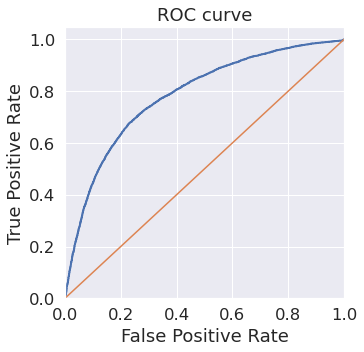

roc auc score: 0.7870081561637485
roc auc score: 0.7840347790421852
Confusion matrix, without normalization
[[4861 3959]
 [1411 7269]]


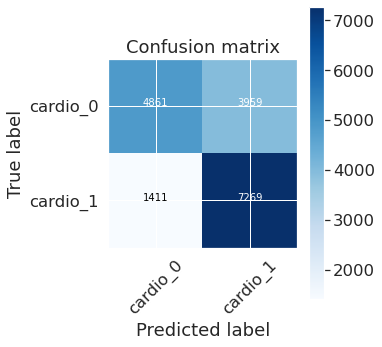

TPR=0.837442396313364, FPR=0.44886621315192743, TNR=0.5511337868480726
**************************************************
Model knn CV score is 0.6912766334769298+-0.0034373176868339114
Best Threshold=0.4, F-Score=0.686, Precision=0.588, Recall=0.822


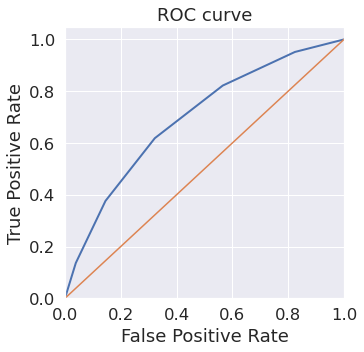

roc auc score: 0.8476614628356242
roc auc score: 0.6940984174007545
Confusion matrix, without normalization
[[5979 2841]
 [3311 5369]]


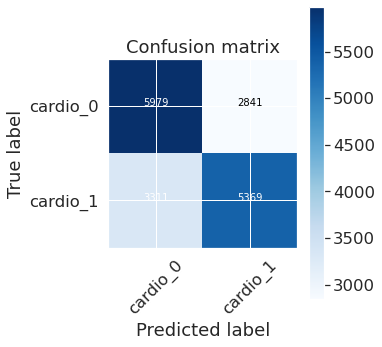

TPR=0.6185483870967742, FPR=0.322108843537415, TNR=0.677891156462585
**************************************************
Model tree CV score is 0.6347715324610604+-0.0036846985455350296
Best Threshold=0.0, F-Score=0.663, Precision=0.496, Recall=1.000


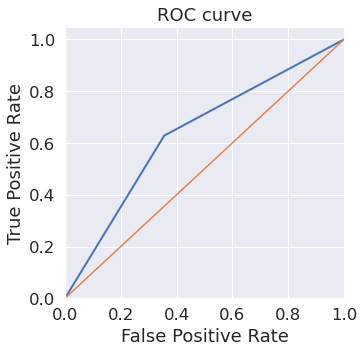

roc auc score: 0.9999999121992406
roc auc score: 0.636307322852336
Confusion matrix, without normalization
[[5677 3143]
 [3222 5458]]


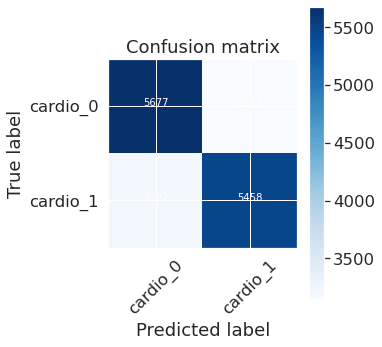

TPR=0.6288018433179724, FPR=0.35634920634920636, TNR=0.6436507936507937
**************************************************
[19:10:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/recpi/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/recpi/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:10:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/recpi/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:11:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/recpi/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:11:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/recpi/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:11:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/recpi/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:11:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/recpi/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:11:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model xgb CV score is 0.7971556512953741+-0.0025807640816467533
[19:11:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/recpi/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Best Threshold=0.3471032679080963, F-Score=0.738, Precision=0.665, Recall=0.828


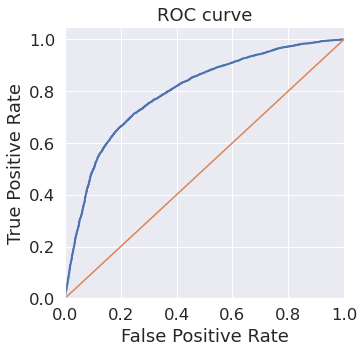

roc auc score: 0.847493341796301
roc auc score: 0.7972277735979184
Confusion matrix, without normalization
[[5202 3618]
 [1491 7189]]


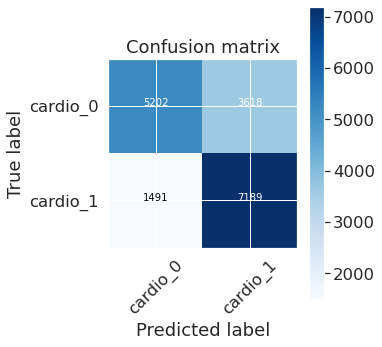

TPR=0.8282258064516129, FPR=0.41020408163265304, TNR=0.5897959183673469
**************************************************
Model lgbm CV score is 0.802022279046519+-0.00314407302836753
Best Threshold=0.3447966167909033, F-Score=0.740, Precision=0.661, Recall=0.840


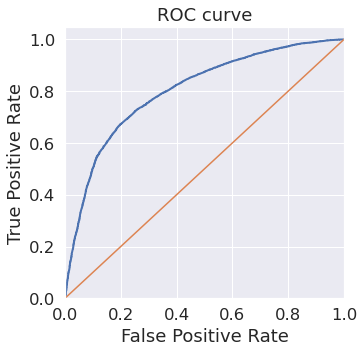

roc auc score: 0.8248323656018283
roc auc score: 0.8016890681003584
Confusion matrix, without normalization
[[5079 3741]
 [1393 7287]]


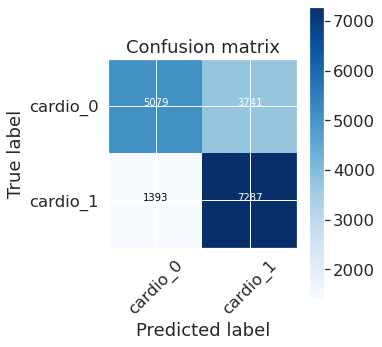

TPR=0.839516129032258, FPR=0.4241496598639456, TNR=0.5758503401360544
**************************************************
Model cat CV score is 0.8019349542977964+-0.003259188171637524
Best Threshold=0.39361797479510247, F-Score=0.739, Precision=0.696, Recall=0.788


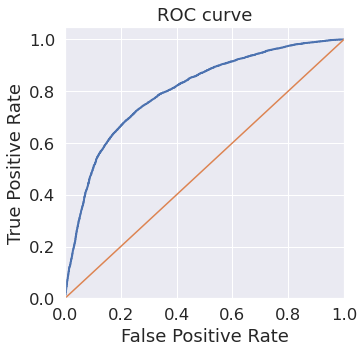

roc auc score: 0.8343855497283699
roc auc score: 0.800766409866558
Confusion matrix, without normalization
[[5833 2987]
 [1839 6841]]


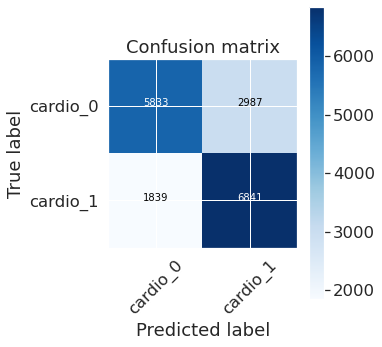

TPR=0.7881336405529954, FPR=0.3386621315192744, TNR=0.6613378684807256
**************************************************


In [13]:
stata, model_all = run_experiment()

In [14]:
stata

,model_name,CV score is,F-Score,Precision,Recall,roc auc score train,roc auc score test,TPR,FPR,TNR,не делать тест,тест и лечить,МЛ,Best Threshold
0,lr,0.786457,0.730323,0.647431,0.837558,0.787008,0.784035,0.837442,0.448866,0.551134,173600000.0,154700000.0,152974200.0,0.386937
1,knn,0.691277,0.685863,0.588468,0.821889,0.847661,0.694098,0.618548,0.322109,0.677891,173600000.0,154700000.0,158249000.0,0.400000
2,tree,0.634772,0.663102,0.496000,1.000000,1.000000,0.636307,0.628802,0.356349,0.643651,173600000.0,154700000.0,158351400.0,0.000000
3,xgb,0.797156,0.737890,0.665248,0.828341,0.847493,0.797228,0.828226,0.410204,0.589796,173600000.0,154700000.0,152784800.0,0.347103
4,lgbm,0.802022,0.739561,0.660803,0.839631,0.824832,0.801689,0.839516,0.424150,0.575850,173600000.0,154700000.0,152604200.0,0.344797
5,cat,0.801935,0.739316,0.696103,0.788249,0.834386,0.800766,0.788134,0.338662,0.661338,173600000.0,154700000.0,153154200.0,0.393618


In [23]:
# model_all

In [21]:
lgbm = model_all[4]

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу больных: 154700000
расходы, если использовать МЛ: 152388000
Расходы "решение не делать тесты - расходы с МL:" 21212000
Расходы "решение не делать тесты - расходы сделать тесты всем": 18900000
Расходы "сделать тесты всем - решение делать тесты ML": 2312000


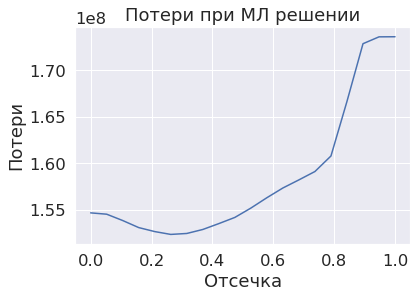

уровень порога по бизнес метрике 0.2631578947368421
уровень порога по f1 метрике 0.3447966167909033


In [22]:
busines_tr = business_threshold_calibrate(lgbm['y_test'], lgbm['y_score'], 
                                          lgbm['threshold'],
                                          rubl_test=1400, 
                                          rubl_early_treatment=15000, 
                                          rubl_late_treatment=20000)

print('уровень порога по бизнес метрике', busines_tr)
print('уровень порога по f1 метрике', lgbm['threshold'])

### lgbm себя показала лучше всех